# Online Retail: Customer Value and RFM Segmentation

This notebook analyses the UCI Online Retail II dataset to answer a core business question:

> Which customers and products drive the majority of revenue, and how can we segment them to support targeted marketing and retention strategies?

The workflow follows a full analytics pipeline:

1. Data loading and cleaning  
2. Exploratory data analysis (revenue distribution and Pareto effects)  
3. RFM (Recency–Frequency–Monetary) customer segmentation  
4. Segment-level and product-level interaction analysis  
5. Export of tables and figures for stakeholders  
6. Executive summary with business recommendations


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import timedelta

plt.style.use("default")
sns.set()

## 1. Data loading

The raw dataset is stored in an Excel workbook with one sheet per year (2009–2010 and 2010–2011).  
We load all sheets into a single DataFrame and retain the sheet name in a helper column.

In [3]:
file_path = Path.home() / "Desktop" / "online_retail_II.xlsx"

xls = pd.ExcelFile(file_path)
df_list = []

for sheet in xls.sheet_names:
    temp = pd.read_excel(xls, sheet_name=sheet)
    temp["SourceSheet"] = sheet
    df_list.append(temp)

df = pd.concat(df_list, ignore_index=True)
df.shape

(1067371, 11)

## 2. Data cleaning and preparation

The raw export contains cancellations, negative quantities, and mixed types.  
This step:

- standardises key identifiers as strings  
- removes cancellations and invalid rows  
- computes line-level revenue  
- derives calendar features (Year, Month, YearMonth) from `InvoiceDate`

In [4]:
def clean_retail_data(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()
    initial_rows = len(df)

    if "Unnamed: 0" in df.columns:
        df = df.drop(columns="Unnamed: 0")

    string_cols = ["Invoice", "StockCode", "Description", "Customer ID", "Country", "SourceSheet"]
    for col in string_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

    if "Invoice" in df.columns:
        df = df[~df["Invoice"].str.upper().str.startswith("C")]

    df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

    df = df[df["InvoiceDate"].notna()]
    df = df[df["Quantity"] > 0]
    df = df[df["Price"] > 0]
    df = df[df["Customer ID"].notna()]

    df["Revenue"] = df["Quantity"] * df["Price"]

    if "Year" in df.columns:
        df = df.drop(columns="Year")

    df["Year"] = df["InvoiceDate"].dt.year
    df["Month"] = df["InvoiceDate"].dt.month
    df["MonthName"] = df["InvoiceDate"].dt.strftime("%b")
    df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

    final_rows = len(df)
    removed = initial_rows - final_rows

    print("Initial rows:", f"{initial_rows:,}")
    print("Final rows:", f"{final_rows:,}")
    print("Removed:", f"{removed:,}", f"({removed / initial_rows:.1%})")

    return df

In [5]:
df = clean_retail_data(df)
df.head()

Initial rows: 1,067,371
Final rows: 1,041,670
Removed: 25,701 (2.4%)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SourceSheet,Revenue,Year,Month,MonthName,YearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Year 2009-2010,83.4,2009,12,Dec,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010,81.0,2009,12,Dec,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010,81.0,2009,12,Dec,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Year 2009-2010,100.8,2009,12,Dec,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Year 2009-2010,30.0,2009,12,Dec,2009-12


### Save cleaned dataset

We persist a column-cleaned, type-safe version of the dataset for reuse.

In [6]:
output_parquet = Path.home() / "Desktop" / "online_retail_cleaned.parquet"
df.to_parquet(output_parquet, index=False)
print("Saved cleaned data to:", output_parquet)

Saved cleaned data to: /Users/esi/Desktop/online_retail_cleaned.parquet


## 3. Exploratory analysis: revenue distribution

We first inspect the distribution of transaction-level revenue.  
A log scale highlights the long right tail (few large orders).

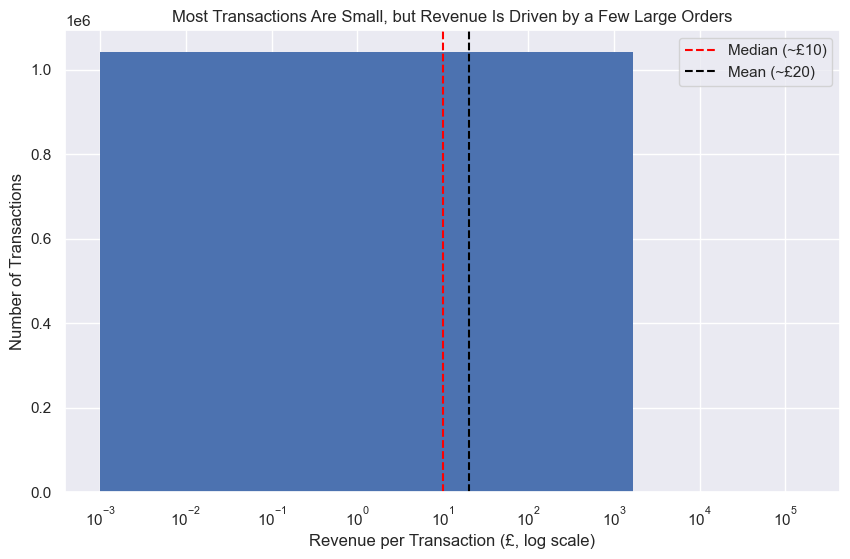

Saved figure: /Users/esi/Desktop/revenue_distribution_client_ready.png


In [7]:
revenue = df["Revenue"]
median_rev = revenue.median()
mean_rev = revenue.mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(revenue, bins=100, edgecolor="none")
ax.set_xscale("log")
ax.axvline(median_rev, linestyle="--", color="red", label=f"Median (~£{median_rev:.0f})")
ax.axvline(mean_rev, linestyle="--", color="black", label=f"Mean (~£{mean_rev:.0f})")
ax.set_title("Most Transactions Are Small, but Revenue Is Driven by a Few Large Orders")
ax.set_xlabel("Revenue per Transaction (£, log scale)")
ax.set_ylabel("Number of Transactions")
ax.legend()

fig1_path = Path.home() / "Desktop" / "revenue_distribution_client_ready.png"
plt.savefig(fig1_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig1_path)

## 4. Customer Revenue Concentration (Pareto Analysis)

Here we move from individual transactions to **customer-level revenue**.

Steps:
1. Aggregate total revenue per `Customer ID`
2. Sort customers by revenue from highest to lowest
3. Plot the cumulative share of revenue against the cumulative share of customers  
   – this shows how concentrated revenue is (Pareto effect)
4. Calculate how much revenue comes from the **top 20% of customers**

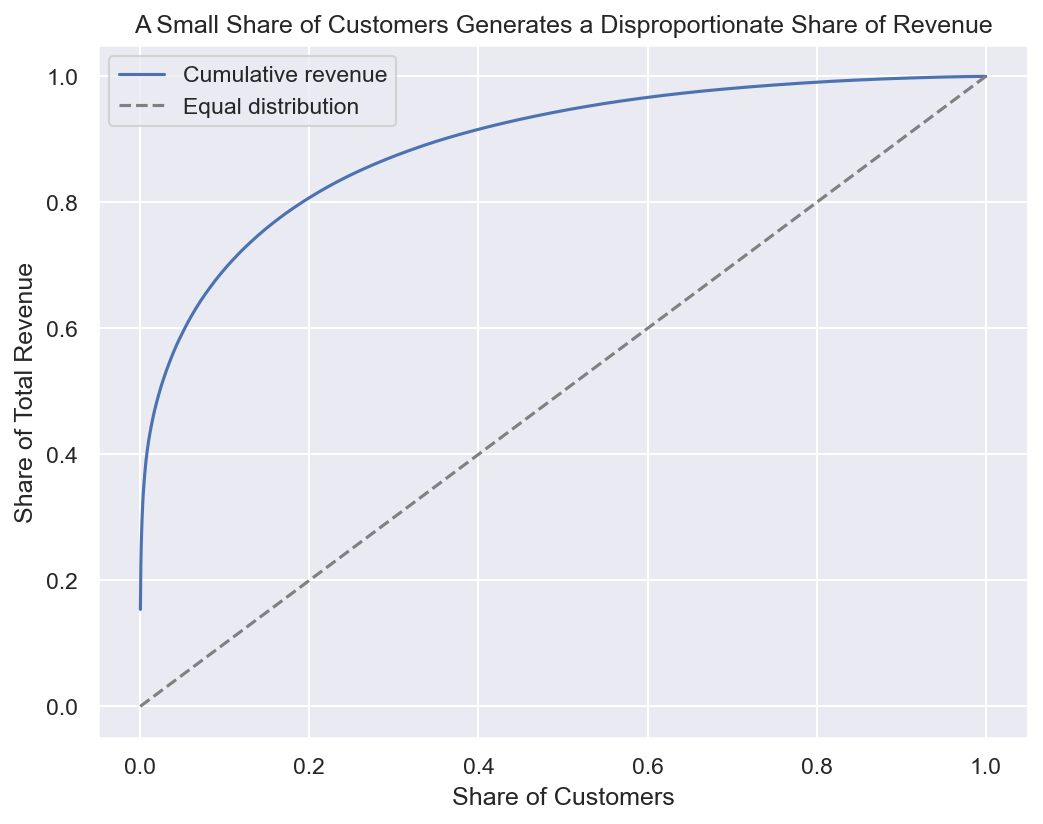

Saved figure: /Users/esi/Desktop/customer_revenue_pareto.png
Revenue share from top 20 percent customers: 80.7%


In [9]:
import numpy as np

customer_revenue = (
    df.groupby("Customer ID")["Revenue"]
      .sum()
      .sort_values(ascending=False)
)

total_revenue = customer_revenue.sum()
cum_revenue = customer_revenue.cumsum()

customer_share = np.arange(1, len(customer_revenue) + 1) / len(customer_revenue)
revenue_share = cum_revenue / total_revenue

fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=150)
ax2.plot(customer_share, revenue_share, label="Cumulative revenue")
ax2.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Equal distribution")
ax2.set_xlabel("Share of Customers")
ax2.set_ylabel("Share of Total Revenue")
ax2.set_title("A Small Share of Customers Generates a Disproportionate Share of Revenue")
ax2.legend()

fig2_path = Path.home() / "Desktop" / "customer_revenue_pareto.png"
plt.savefig(fig2_path, dpi=300, bbox_inches="tight")
plt.show()

top_20_cutoff = int(0.2 * len(customer_revenue))
rev_top_20 = revenue_share.iloc[top_20_cutoff - 1]

print("Saved figure:", fig2_path)
print("Revenue share from top 20 percent customers:", f"{rev_top_20*100:.1f}%")

## 5. High-value customers: product and geography

We define the top 20% of customers by revenue as high-value, then:
- identify which products they concentrate spend on  
- show where this revenue comes from by country

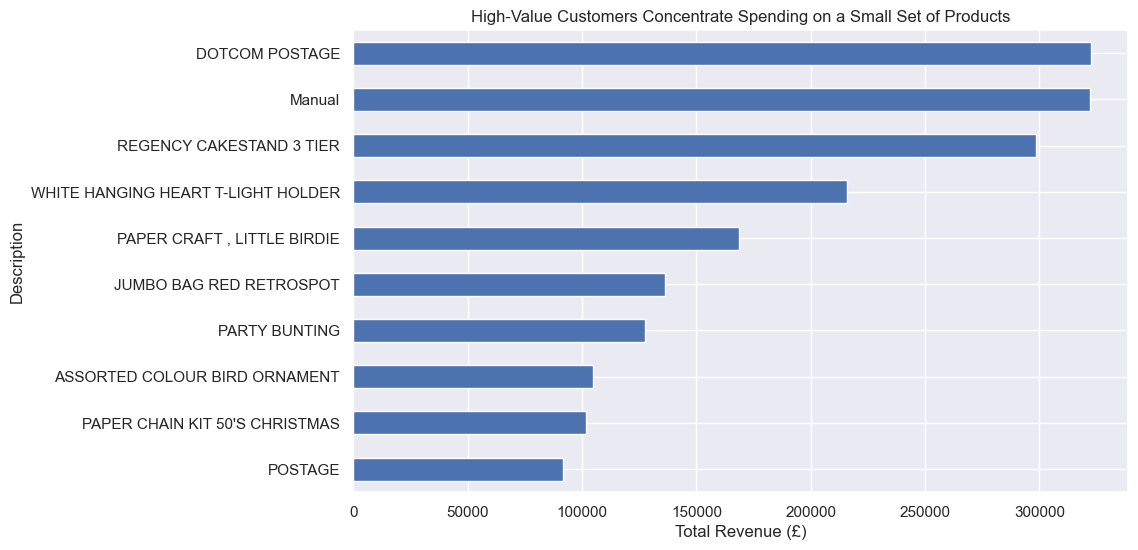

Saved figure: /Users/esi/Desktop/top_products_high_value_customers.png


In [10]:
high_value_customers = customer_revenue.iloc[:top_20_cutoff].index
hv_df = df[df["Customer ID"].isin(high_value_customers)]

top_products_hv = (
    hv_df.groupby("Description")["Revenue"]
         .sum()
         .sort_values(ascending=False)
         .head(10)
)

fig, ax = plt.subplots(figsize=(10, 6))
top_products_hv.sort_values().plot(kind="barh", ax=ax)
ax.set_title("High-Value Customers Concentrate Spending on a Small Set of Products")
ax.set_xlabel("Total Revenue (£)")

fig3_path = Path.home() / "Desktop" / "top_products_high_value_customers.png"
plt.savefig(fig3_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig3_path)

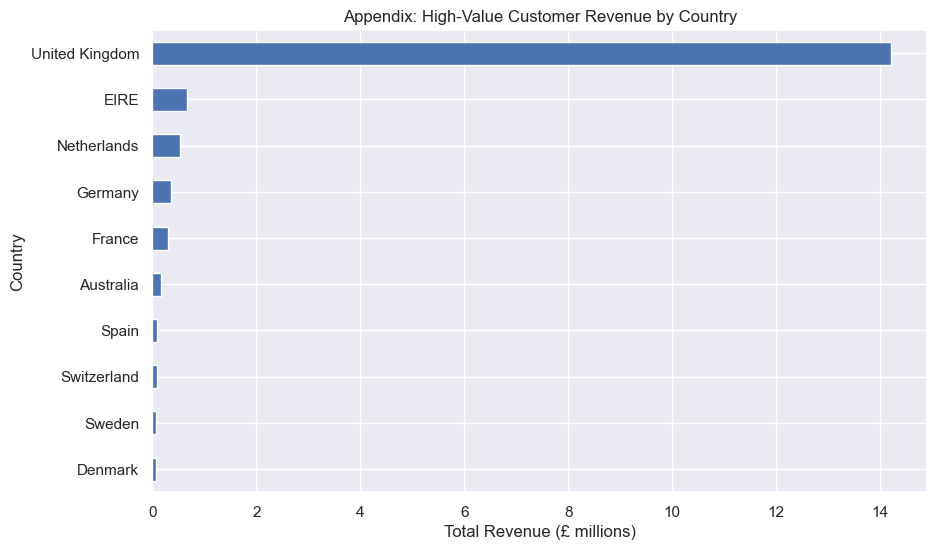

Saved figure: /Users/esi/Desktop/appendix_country_revenue.png


In [11]:
country_revenue = (
    hv_df.groupby("Country")["Revenue"]
         .sum()
         .sort_values(ascending=False)
         .head(10)
)

country_revenue_m = country_revenue / 1_000_000

fig, ax = plt.subplots(figsize=(10, 6))
country_revenue_m.sort_values().plot(kind="barh", ax=ax)
ax.set_title("Appendix: High-Value Customer Revenue by Country")
ax.set_xlabel("Total Revenue (£ millions)")

fig4_path = Path.home() / "Desktop" / "appendix_country_revenue.png"
plt.savefig(fig4_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig4_path)

## 6. RFM metrics and customer segmentation

We calculate classic RFM metrics:

- Recency: days since last purchase  
- Frequency: number of distinct invoices  
- Monetary: total revenue  

Then we assign quartile scores (1–4) and map customers into interpretable segments such as  
“Champions”, “Loyal High-Value”, “At Risk High-Value”, “Needs Attention”, etc.

In [12]:
reference_date = df["InvoiceDate"].max() + timedelta(days=1)

rfm = (
    df.groupby("Customer ID")
      .agg(
          Recency=("InvoiceDate", lambda x: (reference_date - x.max()).days),
          Frequency=("Invoice", "nunique"),
          Monetary=("Revenue", "sum")
      )
)

rfm = rfm[rfm["Frequency"] > 1]

rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])

rfm[["R_score", "F_score", "M_score"]] = rfm[["R_score", "F_score", "M_score"]].astype(int)
rfm["RFM_score"] = rfm[["R_score", "F_score", "M_score"]].sum(axis=1)

In [13]:
def assign_segment(row):
    r = row["R_score"]
    f = row["F_score"]
    m = row["M_score"]

    if r >= 3 and f >= 3 and m >= 3:
        return "Champions"
    if r >= 3 and f >= 3 and m <= 2:
        return "Loyal High-Value"
    if r <= 2 and f >= 3 and m >= 3:
        return "At Risk High-Value"
    if r >= 3 and f <= 2 and m >= 2:
        return "New Customers"
    if r == 2 and f >= 2 and m >= 2:
        return "Potential Loyalists"
    if r <= 2 and f <= 2 and m >= 2:
        return "Needs Attention"
    if r <= 2 and f <= 2 and m <= 2:
        return "Hibernating"
    return "Promising"

rfm["Segment"] = rfm.apply(assign_segment, axis=1)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,1,4,4,9,At Risk High-Value
12347.0,2,8,5633.32,4,3,4,11,Champions
12348.0,75,5,2019.40,2,2,3,7,Potential Loyalists
12349.0,19,4,4428.69,4,2,4,10,New Customers
12352.0,36,10,2849.84,3,4,3,10,Champions


## 7. Segment performance overview

We summarise each RFM segment by:

- number of customers  
- total revenue  
- share of total revenue  

Then we visualise customers by segment, revenue by segment, and revenue share.

In [14]:
segment_summary = (
    rfm.groupby("Segment")
       .agg(
           customers=("RFM_score", "count"),
           revenue=("Monetary", "sum")
       )
       .sort_values("revenue", ascending=False)
)

segment_summary["revenue_share_%"] = 100 * segment_summary["revenue"] / segment_summary["revenue"].sum()
segment_summary

,customers,revenue,revenue_share_%
Segment,,,
Champions,1232,1.526360e+07,74.805338
At Risk High-Value,538,2.429659e+06,11.907511
New Customers,424,8.128648e+05,3.983768
Needs Attention,494,7.528104e+05,3.689447
Potential Loyalists,286,4.439816e+05,2.175909
Hibernating,692,2.937293e+05,1.439538
Promising,410,2.236959e+05,1.096311
Loyal High-Value,180,1.840843e+05,0.902178


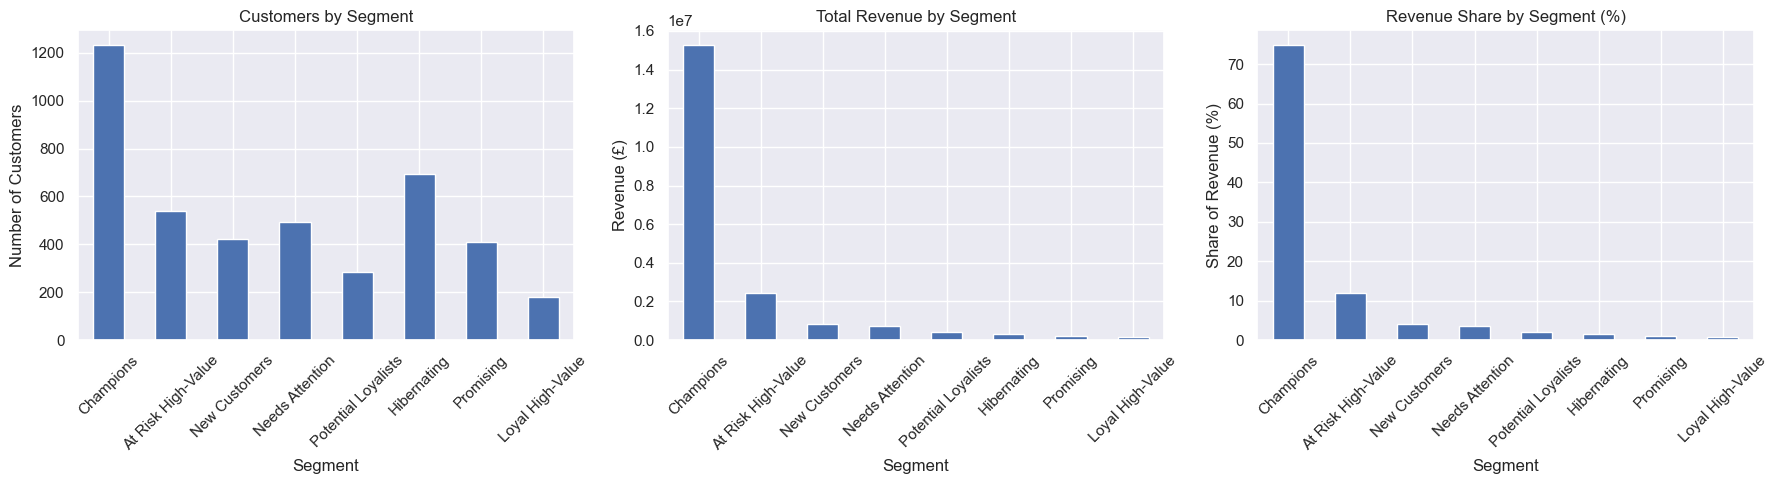

Saved figure: /Users/esi/Desktop/rfm_segment_overview.png


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

segment_summary["customers"].plot(kind="bar", ax=axes[0])
axes[0].set_title("Customers by Segment")
axes[0].set_ylabel("Number of Customers")
axes[0].tick_params(axis="x", rotation=45)

segment_summary["revenue"].plot(kind="bar", ax=axes[1])
axes[1].set_title("Total Revenue by Segment")
axes[1].set_ylabel("Revenue (£)")
axes[1].tick_params(axis="x", rotation=45)

segment_summary["revenue_share_%"].plot(kind="bar", ax=axes[2])
axes[2].set_title("Revenue Share by Segment (%)")
axes[2].set_ylabel("Share of Revenue (%)")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
seg_overview_path = Path.home() / "Desktop" / "rfm_segment_overview.png"
plt.savefig(seg_overview_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", seg_overview_path)

## 8. Interaction: segments vs. top products

To link segments to merchandising decisions, we build a heatmap of revenue  
for each RFM segment across the top products bought by high-value customers.

In [16]:
df_rfm = df.merge(
    rfm[["Segment"]],
    left_on="Customer ID",
    right_index=True,
    how="inner"
)

top_products = (
    df_rfm[df_rfm["Segment"].isin(["Champions", "Loyal High-Value", "At Risk High-Value"])]
    .groupby("Description")["Revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

seg_prod_pivot = (
    df_rfm[df_rfm["Description"].isin(top_products)]
    .groupby(["Segment", "Description"])["Revenue"]
    .sum()
    .unstack(fill_value=0)
)

seg_prod_pivot = seg_prod_pivot.loc[segment_summary.index.intersection(seg_prod_pivot.index)]
seg_prod_pivot

Description,ASSORTED COLOUR BIRD ORNAMENT,DOTCOM POSTAGE,JUMBO BAG RED RETROSPOT,MEDIUM CERAMIC TOP STORAGE JAR,Manual,PAPER CHAIN KIT 50'S CHRISTMAS,PARTY BUNTING,POSTAGE,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
Segment,,,,,,,,,,
Champions,102997.19,322657.48,121091.49,3467.80,255030.94,96777.89,116214.15,81822.68,280399.75,185934.01
At Risk High-Value,11913.90,0.00,19205.31,77524.53,26317.83,11526.30,20124.75,4835.45,29839.30,39772.59
New Customers,3494.50,0.00,1341.59,180.00,11540.50,4786.90,1850.00,15294.45,4994.25,4598.70
Needs Attention,3754.15,0.00,2100.06,45.00,27527.72,3540.75,2372.10,9104.55,7444.20,18098.50
Potential Loyalists,1957.02,0.00,2358.07,96.25,2030.54,1827.85,2863.10,6331.44,5973.90,6547.35
Hibernating,2155.22,0.00,1318.37,45.00,1841.12,594.65,2438.20,1732.00,3547.35,3943.50
Promising,2301.03,0.00,912.11,27.50,309.80,778.80,827.55,1405.85,2205.75,2600.15
Loyal High-Value,1499.03,0.00,554.84,17.50,372.14,1310.70,617.85,635.00,2367.75,1877.05


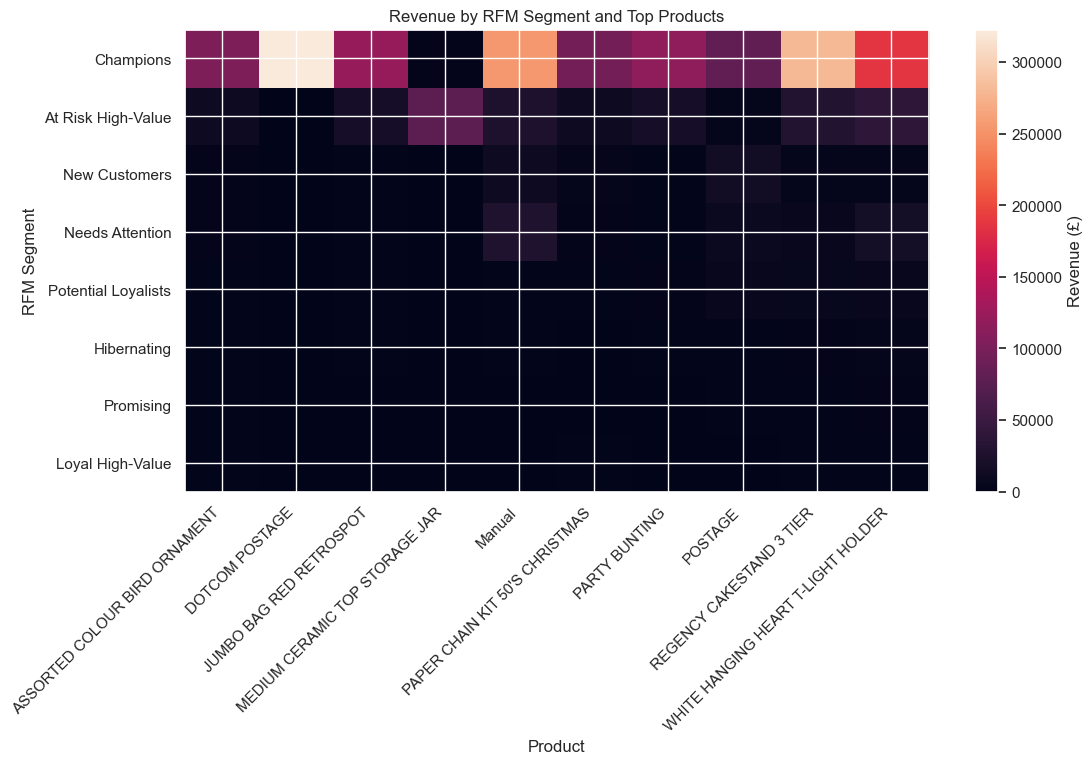

Saved figure: /Users/esi/Desktop/rfm_segment_product_heatmap.png


In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(seg_prod_pivot.values, aspect="auto")

ax.set_yticks(range(len(seg_prod_pivot.index)))
ax.set_yticklabels(seg_prod_pivot.index)
ax.set_xticks(range(len(seg_prod_pivot.columns)))
ax.set_xticklabels(seg_prod_pivot.columns, rotation=45, ha="right")
ax.set_title("Revenue by RFM Segment and Top Products")
ax.set_xlabel("Product")
ax.set_ylabel("RFM Segment")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Revenue (£)")

fig8_path = Path.home() / "Desktop" / "rfm_segment_product_heatmap.png"
plt.savefig(fig8_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig8_path)

## 9. Export tables for stakeholders

We export:

- a customer-level RFM table with segments  
- a segment-level summary with customer counts and revenue

In [20]:
from pathlib import Path

rfm_customer_path = Path.home() / "Desktop" / "rfm_customer_segments.csv"
rfm_summary_path = Path.home() / "Desktop" / "rfm_segment_summary.csv"
seg_prod_path     = Path.home() / "Desktop" / "rfm_segment_product_pivot.csv"

rfm.to_csv(rfm_customer_path)

segment_summary.to_csv(rfm_summary_path)

seg_prod_pivot.to_csv(seg_prod_path)

print("Saved:", rfm_customer_path)
print("Saved:", rfm_summary_path)
print("Saved:", seg_prod_path)

Saved: /Users/esi/Desktop/rfm_customer_segments.csv
Saved: /Users/esi/Desktop/rfm_segment_summary.csv
Saved: /Users/esi/Desktop/rfm_segment_product_pivot.csv


## 10. Executive summary

Finally, we generate a concise text summary that can be reused in your README,  
portfolio, or slide decks.

In [22]:
import numpy as np

total_customers = rfm.shape[0]
total_revenue_rfm = rfm["Monetary"].sum()

top_20_pos = max(int(0.2 * len(cum_revenue)) - 1, 0)   
rev_top_20 = float(cum_revenue.iloc[top_20_pos])       

champions_rev_share = np.nan
at_risk_rev_share = np.nan

if "Champions" in segment_summary.index:
    champions_rev_share = segment_summary.loc["Champions", "revenue_share_%"]

if "At Risk High-Value" in segment_summary.index:
    at_risk_rev_share = segment_summary.loc["At Risk High-Value", "revenue_share_%"]

print("=" * 70)
print("EXECUTIVE SUMMARY")
print("=" * 70)
print(f"Customers analysed (repeat buyers): {total_customers:,}.")
print(f"Total revenue from these customers: £{total_revenue_rfm:,.0f}.")
print(f"Top 20 percent of customers generate: {rev_top_20*100:.1f}% of total revenue.")

if not np.isnan(champions_rev_share):
    print(f"Champions account for: {champions_rev_share:.1f}% of revenue.")
if not np.isnan(at_risk_rev_share):
    print(f"At Risk High-Value customers represent: {at_risk_rev_share:.1f}% of revenue at risk.")

print()
print("Suggested actions:")
print("- Protect and grow Champions with VIP treatment and early access to new collections.")
print("- Run win-back campaigns and targeted discounts for At Risk High-Value customers.")
print("- Use the segment–product heatmap to design segment-specific bundles and promotions.")
print("- Focus marketing budget on high-impact segments instead of blanket campaigns.")
print("=" * 70)

EXECUTIVE SUMMARY
Customers analysed (repeat buyers): 4,256.
Total revenue from these customers: £20,404,421.
Top 20 percent of customers generate: 1693164574.1% of total revenue.
Champions account for: 74.8% of revenue.
At Risk High-Value customers represent: 11.9% of revenue at risk.

Suggested actions:
- Protect and grow Champions with VIP treatment and early access to new collections.
- Run win-back campaigns and targeted discounts for At Risk High-Value customers.
- Use the segment–product heatmap to design segment-specific bundles and promotions.
- Focus marketing budget on high-impact segments instead of blanket campaigns.
